In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed

from models.seir.seir_testing import SEIR_Testing
from data.dataloader import get_global_data, get_indian_data
from data.bbmp_dataloader import loadbbmpdata
from utils.plotting import create_plots
from utils.generic import init_params

## Load BBMP Data

In [75]:
df, df_agg = loadbbmpdata('bbmp-raw.csv')
df_agg = df_agg.iloc[9:-3, :]
df_agg.reset_index(drop=True, inplace=True)

## Create Train-Val Split

In [36]:
df_train = df_agg.loc[:27, :]
df_val = df_agg.loc[28:, :]
df_val

,Date,Active Infections (Unknown),Hospitalised,On ICU,On Ventilator,Fatalities,Total Infected,Recovered
28,2020-04-05,15,39,3,2,0,49,15
29,2020-04-06,17,49,3,2,0,64,18
30,2020-04-07,2,47,3,2,0,65,18
31,2020-04-08,3,48,3,2,0,66,18
32,2020-04-09,2,48,3,2,0,66,18
33,2020-04-10,2,48,3,2,0,66,18
34,2020-04-11,2,50,3,2,0,68,18


In [60]:
df_val

,Date,Active Infections (Unknown),Hospitalised,On ICU,On Ventilator,Fatalities,Total Infected,Recovered
28,2020-04-05,15,39,3,2,0,49,15
29,2020-04-06,17,49,3,2,0,64,18
30,2020-04-07,2,47,3,2,0,65,18
31,2020-04-08,3,48,3,2,0,66,18
32,2020-04-09,2,48,3,2,0,66,18
33,2020-04-10,2,48,3,2,0,66,18
34,2020-04-11,2,50,3,2,0,68,18


## Loss Calculation Functions

In [68]:
def _calc_rmse(y_true, y_pred, log=True):
    if log:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)
    loss = np.sqrt(np.mean((y_true - y_pred)**2))
    return loss

def _calc_mape(y_true, y_pred):
    y_pred = y_pred[y_true > 0]
    y_true = y_true[y_true > 0]

    ape = np.abs((y_true - y_pred + 0) / y_true) *  100
    loss = np.mean(ape)
    return loss

def calc_loss_dict(states_time_matrix, df, method='rmse', rmse_log=False):
    pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    pred_recoveries = states_time_matrix[9]
    pred_fatalities = states_time_matrix[10]
    pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    
    if method == 'rmse':
        if rmse_log:
            calculate = lambda x, y : _calc_rmse(x, y)
        else:
            calculate = lambda x, y : _calc_rmse(x, y, log=False)
    
    if method == 'mape':
            calculate = lambda x, y : _calc_mape(x, y)
    
    losses = {}
    losses['hospitalised'] = calculate(pred_hospitalisations, df['Hospitalised'])
    losses['recovered'] = calculate(pred_recoveries, df['Recovered'])
    losses['fatalities'] = calculate(pred_fatalities, df['Fatalities'])
    losses['active_infections'] = calculate(pred_infectious_unknown, df['Active Infections (Unknown)'])
    losses['total'] = calculate(pred_total_cases, df['Total Infected'])
    
    return losses

def calc_loss(states_time_matrix, df, method='rmse', rmse_log=False):
    losses = calc_loss_dict(states_time_matrix, df, method, rmse_log)
    loss = losses['hospitalised'] + losses['recovered'] + losses['total'] + losses['active_infections']
    return loss

## Fitting Helper Functions

In [69]:
def get_country_dataframe(df_master, country):
    df_country = df_master[df_master['Country/Region'] == country].loc[:, 'Date':].groupby('Date').sum().reset_index()
    df_country = df_country[df_country['ConfirmedCases'] > 0]
    total_days = len(df_country['Date'])
    df_country.reset_index(drop=True, inplace=True)
    return df_country

def solve_and_compute_loss(variable_params, default_params, df, total_days, method='rmse'):
    params_dict = {**variable_params, **default_params}
    vanilla_params, testing_params, state_init_values = init_params(**params_dict)
    solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
    sol = solver.solve_ode(total_no_of_days=total_days - 1, time_step=1, method='Radau')
    states_time_matrix = (sol.y*vanilla_params['N']).astype('int')
    return calc_loss(states_time_matrix, df, method)

def _create_dict(param_names, values):
    params_dict = {param_names[i]: values[i] for i in range(len(values))}
    return params_dict

## Fitting Functions

In [70]:
def gridsearch(df_true, place='Bangalore', N=1e7, offset=0, lockdown_date='2020-03-25', lockdown_removal_date='2020-05-03'):
    if place == 'Italy':
        df_true = get_country_dataframe(df_true, place)
        
    df_true_fitting = df_true.loc[offset:, :]
    df_true_fitting.reset_index(drop=True, inplace=True)
    
    total_days = len(df_true_fitting['Date'])
    init_infected = max(df_true_fitting.loc[0, 'Total Infected'], 1)
    start_date = df_true_fitting.loc[0, 'Date']
    intervention_date = datetime.datetime.strptime(lockdown_date, '%Y-%m-%d')
    lockdown_removal_date = datetime.datetime.strptime(lockdown_removal_date, '%Y-%m-%d')
    
    default_params = {
        'N' : N,
        'init_infected' : init_infected,
        'intervention_day' : (intervention_date - start_date).days,
        'lockdown_removal_day' : (lockdown_removal_date - start_date).days,
        'T_hosp' : 0.001,
        'P_fatal' : 0.01
    }
    
    param_ranges = {
        'R0' : np.linspace(1.8, 3, 13),
        'T_inc' : np.linspace(3, 5, 5),
        'T_inf' : np.linspace(2.5, 3.5, 5),
        'T_recov_severe' : np.linspace(11, 15, 10),
        'P_severe' : np.linspace(0.3, 0.9, 25),
        'intervention_amount' : np.linspace(0.4, 1, 31)
    }
    
    rangelists = list(param_ranges.values())
    cartesian_product_tuples = itertools.product(*rangelists)
    list_of_param_dicts = [_create_dict(list(param_ranges.keys()), values) for values in cartesian_product_tuples]
    
    loss_array = Parallel(n_jobs=40)(delayed(solve_and_compute_loss)(params_dict, default_params, df_true_fitting, total_days) for params_dict in tqdm(list_of_param_dicts))
                
    return loss_array, list_of_param_dicts, df_true, df_true_fitting

def bayes_opt(df_true, place='Bangalore', N=1e7, offset=0, lockdown_date='2020-03-25', lockdown_removal_date='2020-05-03', method='rmse'):
    if place == 'Italy':
        df_true = get_country_dataframe(df_true, place)
        
    df_true_fitting = df_true.loc[offset:, :]
    df_true_fitting.reset_index(drop=True, inplace=True)
    
    total_days = len(df_true_fitting['Date'])
    init_infected = max(df_true_fitting.loc[0, 'Total Infected'], 1)
    start_date = df_true_fitting.loc[0, 'Date']
    intervention_date = datetime.datetime.strptime(lockdown_date, '%Y-%m-%d')
    lockdown_removal_date = datetime.datetime.strptime(lockdown_removal_date, '%Y-%m-%d')
    
    variable_params = {
        'R0' : hp.uniform('R0', 1, 3),
        'T_inc' : hp.uniform('T_inc', 3, 5),
        'T_inf' : hp.uniform('T_inf', 2.5, 3.5),
        'T_recov_severe' : hp.uniform('T_recov_severe', 9, 17),
        'P_severe' : hp.uniform('P_severe', 0.3, 0.99),
        'intervention_amount' : hp.uniform('intervention_amount', 0.4, 1)
    }
    
    default_params = {
        'N' : N,
        'init_infected' : init_infected,
        'intervention_day' : (intervention_date - start_date).days,
        'lockdown_removal_day' : (lockdown_removal_date - start_date).days,
        'T_hosp' : 0.001,
        'P_fatal' : 0.01
    }
    
    partial_solve_and_compute_loss = partial(solve_and_compute_loss, default_params = default_params, df=df_true_fitting, total_days=total_days, 
                                            method = method) 
    
    searchspace = variable_params
    
    trials = Trials()
    best = fmin(partial_solve_and_compute_loss,
                space=searchspace,
                algo=tpe.suggest,
                max_evals=5000,
                trials=trials)
    
    return best, trials, default_params


## Fitting

In [36]:
loss_array, list_of_param_dicts, df_country, df_country_fitting = gridsearch(df_agg, offset=9)




  0%|          | 0/3487500 [00:00<?, ?it/s]


  0%|          | 40/3487500 [00:05<130:03:37,  7.45it/s]


  0%|          | 80/3487500 [00:06<99:05:55,  9.78it/s] 


  0%|          | 120/3487500 [00:06<70:35:55, 13.72it/s]


  0%|          | 160/3487500 [00:06<50:09:40, 19.31it/s]


  0%|          | 200/3487500 [00:06<36:12:23, 26.75it/s]


  0%|          | 240/3487500 [00:07<26:09:31, 37.03it/s]


  0%|          | 360/3487500 [00:07<18:45:25, 51.64it/s]


  0%|          | 440/3487500 [00:07<13:31:47, 71.59it/s]


  0%|          | 520/3487500 [00:07<9:51:37, 98.23it/s] 


  0%|          | 680/3487500 [00:07<7:13:36, 134.02it/s]


  0%|          | 840/3487500 [00:07<5:17:28, 183.04it/s]


  0%|          | 1320/3487500 [00:07<3:48:11, 254.63it/s]


  0%|          | 1640/3487500 [00:08<2:50:07, 341.49it/s]


  0%|          | 1960/3487500 [00:08<2:08:08, 453.33it/s]


  0%|          | 2280/3487500 [00:08<1:41:00, 575.07it/s]


  0%|          | 2600/3487500 [00:08<1:17:40, 747.78it/s]


  

In [76]:
best1, trials1, default_params = bayes_opt(df_train, offset=0, method='mape')

100%|██████████| 5000/5000 [06:45<00:00, 12.32trial/s, best loss: 222.24181011846343]


In [77]:
print(best1)
print(best)

{'P_severe': 0.9894425402565591, 'R0': 2.0088665909334997, 'T_inc': 3.000373339080295, 'T_inf': 2.764482161604866, 'T_recov_severe': 9.591701993861486, 'intervention_amount': 0.4003086019253494}
{'P_severe': 0.9891876232061978, 'R0': 1.7576403915286998, 'T_inc': 3.266287742595564, 'T_inf': 2.7140368847441434, 'T_recov_severe': 12.640142561319982, 'intervention_amount': 0.4002846589297868}


## Post Fitting Evaluation + Plotting

In [65]:
def evaluate_losses(best, default_params, df_train, df_val):
    start_date = df_train.iloc[0, 0]
    simulate_till = df_val.iloc[-1, 0]
    total_no_of_days = (simulate_till - start_date).days + 1
    no_of_train_days = (df_train.iloc[-1, 0] - start_date).days + 1
    no_of_val_days = total_no_of_days - no_of_train_days
    
    final_params = {**best, **default_params}
    vanilla_params, testing_params, state_init_values = init_params(**final_params)
    solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
    sol = solver.solve_ode(total_no_of_days=total_no_of_days - 1, time_step=1, method='Radau')
    states_time_matrix = (sol.y*vanilla_params['N']).astype('int')

    train_output = states_time_matrix[:, :no_of_train_days]
    val_output = states_time_matrix[:, -no_of_val_days:]
    
    rmse_loss = calc_loss_dict(train_output, df_train, method='rmse')
    rmse_loss = pd.DataFrame.from_dict(rmse_loss, orient='index', columns=['rmse'])
    
    mape_loss = calc_loss_dict(train_output, df_train, method='mape')
    mape_loss = pd.DataFrame.from_dict(mape_loss, orient='index', columns=['mape'])
    
    train_losses = pd.concat([rmse_loss, mape_loss], axis=1)
    
    rmse_loss = calc_loss_dict(val_output, df_val, method='rmse')
    rmse_loss = pd.DataFrame.from_dict(rmse_loss, orient='index', columns=['rmse'])
    
    mape_loss = calc_loss_dict(val_output, df_val, method='mape')
    mape_loss = pd.DataFrame.from_dict(mape_loss, orient='index', columns=['mape'])
    
    val_losses = pd.concat([rmse_loss, mape_loss], axis=1)
    
    print(train_losses)
    print(val_losses)
    
    return train_losses, val_losses

In [66]:
train_losses, val_losses = evaluate_losses(best1, default_params, df_train, df_val)

                       rmse        mape
hospitalised       6.614378   45.486908
recovered          3.406926   44.372489
fatalities         0.000000         NaN
active_infections  6.726812  120.796485
total              8.762746   41.163139
                        rmse       mape
hospitalised       11.710801  19.616079
recovered          10.447146  34.340536
fatalities          0.000000        NaN
active_infections   5.656854  77.874150
total              22.677868  26.032377


In [45]:
def evaluate_top_params(loss_array, list_of_param_dicts, df_country, df_country_fitting, num_samples=1000, lockdown_removal_date='2020-04-30', 
                        simulate_till = '2020-04-30'):
    
    start_date = df_country_fitting.loc[0, 'Date']
    lockdown_removal_date = datetime.datetime.strptime(lockdown_removal_date, '%Y-%m-%d')
    simulate_till = datetime.datetime.strptime(simulate_till, '%Y-%m-%d')
    new_params = {
        'lockdown_removal_day' : (lockdown_removal_date - start_date).days
    }

    indices = np.argsort(loss_array)[:num_samples]
    columns = ['Date']+list(map(lambda x : str(x), np.arange(11)))
    df_predictions = pd.DataFrame(columns = columns)

    for idx in indices:
        
        daterange = pd.date_range(start=start_date, end=simulate_till)
        
        
        data = np.concatenate((daterange.to_numpy().reshape(-1, 1), states_time_matrix.T.astype('object')), axis=1)
        df = pd.DataFrame(data=data, columns=columns)
        df_predictions = pd.concat([df_predictions, df])

    df_predictions['Date'] = pd.to_datetime(df_predictions['Date'])
    df_predictions['hospitalised'] = (df_predictions['6'] + df_predictions['7'] + df_predictions['8']).astype('int')
    df_predictions['recoveries'] = (df_predictions['9']).astype('int')
    df_predictions['fatalities'] = (df_predictions['10']).astype('int')
    df_predictions['infectious_unknown'] = (df_predictions['2'] + df_predictions['4']).astype('int')
    df_predictions['total_cases'] = (df_predictions['hospitalised'] + df_predictions['recoveries'] + df_predictions['fatalities']).astype('int')
    
    return df_predictions

In [ ]:
df_predictions = evaluate_top_params(loss_array, list_of_param_dicts, df_country, df_country_fitting, 
                                     num_samples=1000, lockdown_removal_date='2020-04-30', simulate_till = '2020-05-15')

df_predictions1 = evaluate_top_params(loss_array, list_of_param_dicts, df_country, df_country_fitting, 
                                     num_samples=1000, lockdown_removal_date='2020-04-14', simulate_till = '2020-05-15')

df_predictions2 = evaluate_top_params(loss_array, list_of_param_dicts, df_country, df_country_fitting, 
                                     num_samples=1000, lockdown_removal_date='2020-05-15', simulate_till = '2020-05-15')

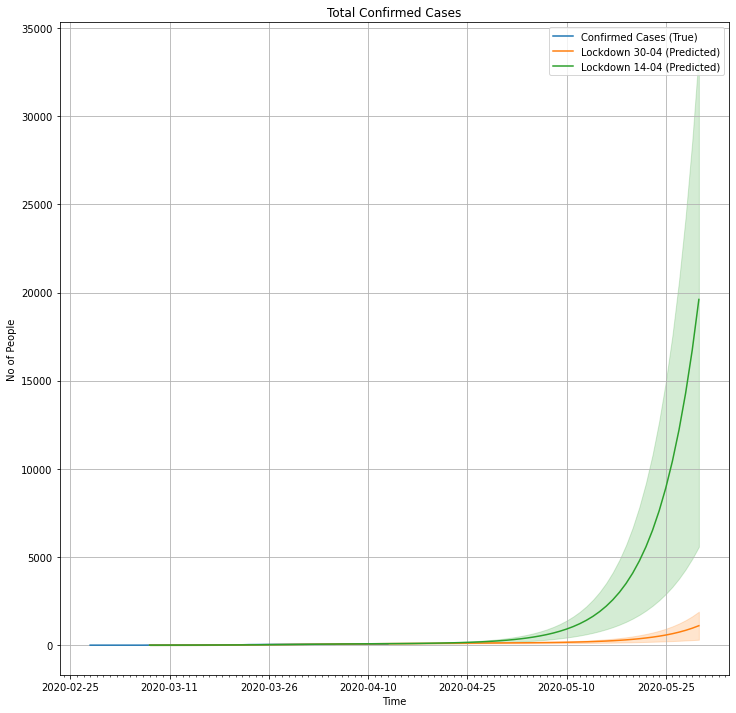

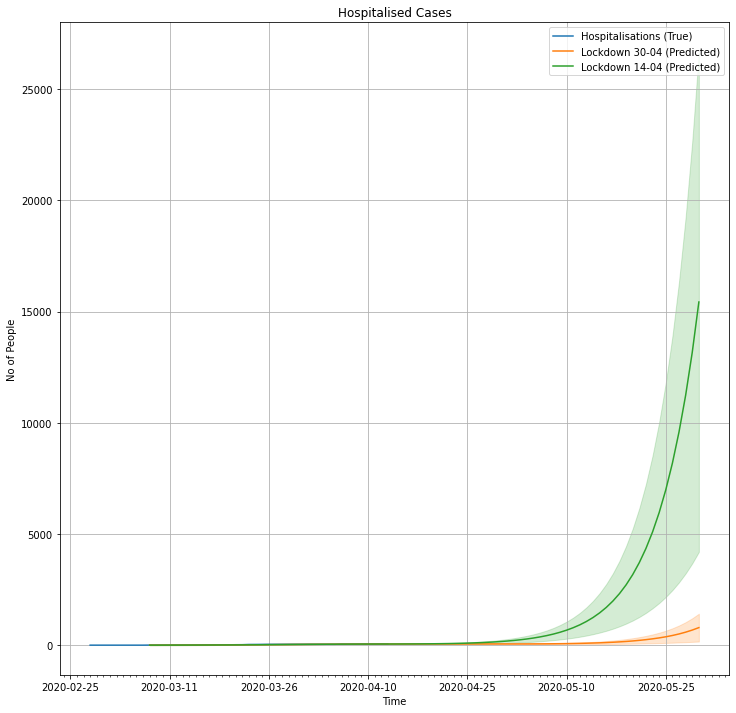

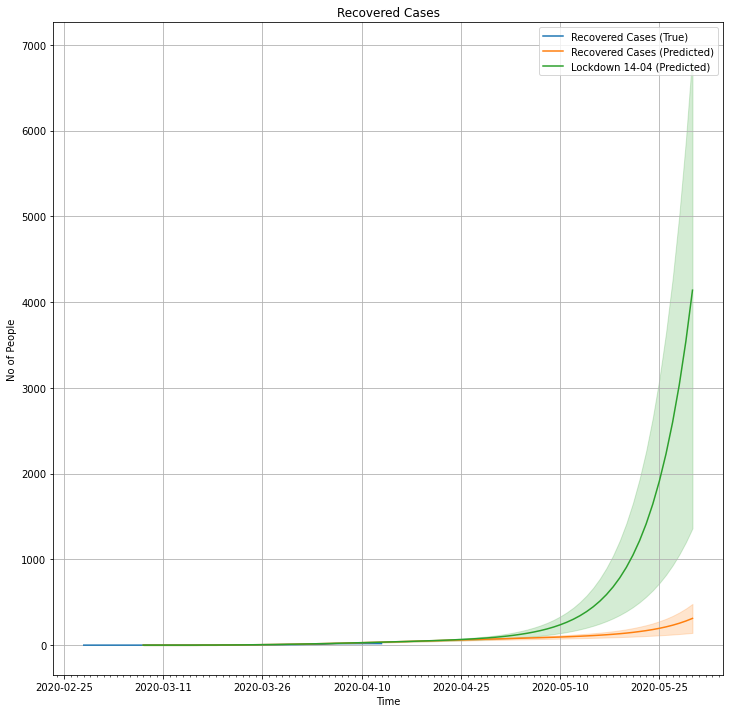

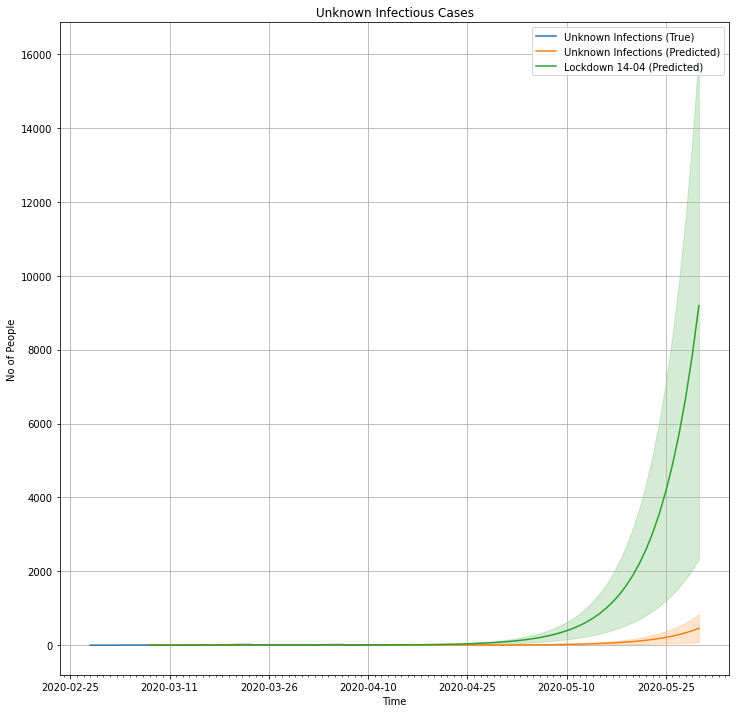

In [52]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['Total Infected'], label='Confirmed Cases (True)')
sns.lineplot(x=df_predictions["Date"], y=df_predictions["total_cases"], ci='sd', label='Lockdown 30-04 (Predicted)')
sns.lineplot(x=df_predictions1["Date"], y=df_predictions1["total_cases"], ci='sd', label='Lockdown 14-04 (Predicted)')
sns.lineplot(x=df_predictions2["Date"], y=df_predictions2["total_cases"], ci='sd', label='Lockdown 15-05 (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('Total Confirmed Cases')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['Hospitalised'], label='Hospitalisations (True)')
sns.lineplot(x=df_predictions["Date"], y=df_predictions["hospitalised"], ci='sd', label='Lockdown 30-04 (Predicted)')
sns.lineplot(x=df_predictions1["Date"], y=df_predictions1["hospitalised"], ci='sd', label='Lockdown 14-04 (Predicted)')
sns.lineplot(x=df_predictions2["Date"], y=df_predictions2["hospitalised"], ci='sd', label='Lockdown 15-05 (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('Hospitalised Cases')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['Recovered'], label='Recovered Cases (True)')
sns.lineplot(x=df_predictions["Date"], y=df_predictions["recoveries"], ci='sd', label='Recovered Cases (Predicted)')
sns.lineplot(x=df_predictions1["Date"], y=df_predictions1["recoveries"], ci='sd', label='Lockdown 14-04 (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('Recovered Cases')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['Active Infections (Unknown)'], label='Unknown Infections (True)')
sns.lineplot(x=df_predictions["Date"], y=df_predictions["infectious_unknown"], ci='sd', label='Unknown Infections (Predicted)')
sns.lineplot(x=df_predictions1["Date"], y=df_predictions1["infectious_unknown"], ci='sd', label='Lockdown 14-04 (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.title('Unknown Infectious Cases')
plt.grid()
plt.show()